In [ ]:
# General libraries
import os
import re
import random
import statistics
import collections
from collections import Counter

# Data handling
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm, colors, colorbar
from sklearn.manifold import TSNE
from matplotlib_venn import venn2

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
mmscaler = MinMaxScaler()

# Feature selection
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy

# Decomposition
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')

# Dimensionality reduction
from pyts.utils import windowed_view

# Statistical tests and models
import statsmodels.api as sm
from scipy.stats import (ttest_ind, levene, mannwhitneyu, shapiro, mstats)
from statannot import add_stat_annotation
from statsmodels.stats.multitest import multipletests

# Machine learning models
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

# Classifiers
rdg = RidgeClassifier(alpha=0.5)
mlp = MLPClassifier(random_state=1, max_iter=300, activation='relu')
lgr = LogisticRegression(random_state=1, max_iter=500)
DT = DecisionTreeClassifier(random_state=0, max_depth=10)
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
SGD = SGDClassifier(loss='log', random_state=1, max_iter=100, early_stopping=True,
                    learning_rate='optimal', validation_fraction=0.2)
rf = RandomForestClassifier(max_depth=10, random_state=0)
clf_svm = SVC(kernel='rbf')

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Model selection and validation
from sklearn.model_selection import (
    train_test_split, LeaveOneOut, StratifiedKFold, GridSearchCV, cross_val_score
)

# Shapelet learning
from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint

# Geometry
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Progress bar
from tqdm import tqdm

# Others
import umap
from sklearn.metrics import pairwise_distances
from scipy.stats import ttest_ind
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict
from matplotlib.lines import Line2D

##### 1. find which of key miRNAs are validated 

All key miRNAs are validated (have evidences of experimental illumina, cloned etc)

##### 2. use miRwalk (integrated databases) to find the genes each miRNA targets 
`\yueyu91p\OneDrive - University of Otago\miRPath-v4-miRNA-centric_analysis_2025-05-28.csv`

##### 3. use target genes to see what KEGG/ontology pathways they involve 


--------------------------------------

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data')
#os.listdir()

##### 2.1 Filter Out High-Confidence Genes Using miRWalk

[miRWalk Interaction Database](http://mirwalk.umm.uni-heidelberg.de/interactions/?mirnaid=&genesymbol=&bindingp=0.8&position=3UTR&targetscan=0&mirdb=0&mirtarbase=0&submit=set+filter)

**Filtering Criteria:**
1. Score > 0.9 *(filtered out >0.8 in the uploaded `.csv`), in the below code further filered to >=0.9*
2. Validated (appear in miRTarBase) *(already filtered out in the uploaded `.csv`)*
3. Appear in either TargetScan or miRDB *(see code below)*


In [ ]:
target_gene_df=pd.read_csv('miRWalk_miRNA_Targets.csv')
target_gene_df_filtered= target_gene_df[(target_gene_df['TargetScan'] == 1) | (target_gene_df['miRDB'] == 1)]
target_gene_df_filtered=target_gene_df_filtered[target_gene_df_filtered['bindingp']>=0.9]

In [ ]:
resp_mirna_names=['hsa-miR-4454','hsa-miR-7975','hsa-miR-574-5p', 'hsa-miR-378i']
persist_mirna_names=['hsa-miR-30a-5p','hsa-miR-127-3p','hsa-miR-151a-3p','hsa-miR-320e']
weightmodel_mirna_names=['hsa-miR-630', 'hsa-miR-370-3p']

In [ ]:
def get_unique_genesymbols(mirna_list, mirna_data):
    """
    For a given list of miRNA names, find matching 'mirnaid' and return unique 'genesymbol' values.
    
    Args:
        mirna_list (list): List of miRNA names (e.g., ['hsa-miR-21', 'hsa-miR-155']).
        mirna_data (pd.DataFrame): DataFrame with columns 'mirnaid' and 'genesymbol'.
    
    Returns:
        list: Unique genesymbol values associated with the miRNAs.
    """
    # Filter rows where 'mirnaid' matches any miRNA in the input list
    matched_genes = mirna_data[mirna_data['mirnaid'].isin(mirna_list)]['genesymbol']
    
    # Remove duplicates and convert to list
    unique_genes = matched_genes.drop_duplicates().tolist()
    
    return unique_genes

In [ ]:
# Get unique genesymbols for each list
resp_genes = get_unique_genesymbols(resp_mirna_names,target_gene_df_filtered)
persist_genes = get_unique_genesymbols(persist_mirna_names, target_gene_df_filtered)
weightmodel_genes = get_unique_genesymbols(weightmodel_mirna_names, target_gene_df_filtered)

print("resp_mirna_names genes:", resp_genes)
print("persist_mirna_names genes:", persist_genes)
print("weightmodel_mirna_names genes:", weightmodel_genes)

In [ ]:
all_genes_combined = resp_genes + persist_genes + weightmodel_genes
all_genes_combined_upper = [gene.upper() for gene in all_genes_combined]

print( 'total number of unique genes: ', len(set(all_genes_combined_upper)) )

In [ ]:
baseline_obese_genes= list(set(resp_genes).symmetric_difference(set(persist_genes)))
#save_list_to_txt(baseline_obese_genes, "baseline_obese_genes.txt")

pwl_obese_genes= list(set(weightmodel_genes).symmetric_difference(set(persist_genes)))
#save_list_to_txt(pwl_obese_genes, "pwl_obese_genes.txt")

### GeneCard to which of our genes here are previous associated with Obesity

Searched: **obesity or body mass index or body fat mass**

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/')
genecard_obesity_bmi_fat_genes=pd.read_csv('GeneCards_obeisty_BMI_fat.csv')

In [ ]:
def process_and_visualize_genes(baseline_obese_genes, pwl_obese_genes, genecard_obesity_genes, 
                               plot_title="Relevance Scores for Genes", 
                               baseline_color="skyblue", pwl_color="salmon", 
                               both_color="mediumpurple"
                               , return_fig=False):
    """
    Process two gene lists against GeneCard obesity genes dataframe and visualize relevance scores
    with different colors indicating gene list membership, and print counts of significant genes.
    
    Parameters:
    baseline_obese_genes (list): First list of gene symbols
    pwl_obese_genes (list): Second list of gene symbols
    genecard_obesity_genes (pd.DataFrame): DataFrame containing GeneCard data with 
                                           'Gene Symbol' and 'Relevance score' columns
    plot_title (str): Title for the visualization plot (default: "Relevance Scores for Genes")
    baseline_color (str): Color for genes only in baseline list (default: "skyblue")
    pwl_color (str): Color for genes only in pwl list (default: "salmon")
    both_color (str): Color for genes in both lists (default: "mediumpurple")
    
    Returns:
    pd.DataFrame: New dataframe with gene symbols, their relevance scores, and membership info
    """
    
    # Validate input dataframe
    if not isinstance(genecard_obesity_genes, pd.DataFrame):
        raise ValueError("genecard_obesity_genes must be a pandas DataFrame")
    
    required_columns = {'Gene Symbol', 'Relevance score'}
    if not required_columns.issubset(genecard_obesity_genes.columns):
        missing = required_columns - set(genecard_obesity_genes.columns)
        raise ValueError(f"Input dataframe is missing required columns: {missing}")
    
    # Convert to sets for faster membership testing
    baseline_set = set(baseline_obese_genes)
    pwl_set = set(pwl_obese_genes)
    
    # Initialize counters
    baseline_count = 0
    pwl_count = 0
    both_count = 0
    
    # Create a dictionary to store gene information
    gene_info = []
    
    # First process baseline genes to count matches
    print("\nProcessing baseline genes...")
    for gene in tqdm(baseline_obese_genes, desc="Baseline genes"):
        match = genecard_obesity_genes[
            genecard_obesity_genes['Gene Symbol'].str.upper() == gene.upper()
        ]
        
        if not match.empty:
            try:
                relevance_score = float(match['Relevance score'].values[0])
                if relevance_score > 0:
                    baseline_count += 1
            except (ValueError, TypeError):
                pass
    
    # Then process PWL genes to count matches
    print("\nProcessing PWL genes...")
    for gene in tqdm(pwl_obese_genes, desc="PWL genes"):
        match = genecard_obesity_genes[
            genecard_obesity_genes['Gene Symbol'].str.upper() == gene.upper()
        ]
        
        if not match.empty:
            try:
                relevance_score = float(match['Relevance score'].values[0])
                if relevance_score > 0:
                    pwl_count += 1
            except (ValueError, TypeError):
                pass
    
    # Count genes in both lists with relevance > 0
    common_genes = baseline_set & pwl_set
    print("\nProcessing genes common to both lists...")
    for gene in tqdm(common_genes, desc="Common genes"):
        match = genecard_obesity_genes[
            genecard_obesity_genes['Gene Symbol'].str.upper() == gene.upper()
        ]
        
        if not match.empty:
            try:
                relevance_score = float(match['Relevance score'].values[0])
                if relevance_score > 0:
                    both_count += 1
            except (ValueError, TypeError):
                pass
    
    # Print the counts
    print(f"\nGene counts with relevance score > 0:")
    print(f"- Baseline list: {baseline_count} genes out of {len(baseline_obese_genes)} genes ")
    print(f"- PWL list: {pwl_count} genes out of {len(pwl_obese_genes)} genes")
    
    # Now process all unique genes for visualization
    all_genes = list(baseline_set.union(pwl_set))
    print("\nProcessing all unique genes for visualization...")
    
    for gene in tqdm(all_genes, desc="All genes"):
        match = genecard_obesity_genes[
            genecard_obesity_genes['Gene Symbol'].str.upper() == gene.upper()
        ]
        
        if not match.empty:
            try:
                relevance_score = float(match['Relevance score'].values[0])
                if relevance_score > 0:
                    in_baseline = gene in baseline_set
                    in_pwl = gene in pwl_set
                    
                    if in_baseline and in_pwl:
                        membership = 'Both'
                    elif in_baseline:
                        membership = 'Baseline only'
                    else:
                        membership = 'PWL only'
                        
                    gene_info.append({
                        'Gene Symbol': gene,
                        'Relevance Score': relevance_score,
                        'Membership': membership
                    })
            except (ValueError, TypeError):
                pass
    
    # Create a new dataframe from the collected info
    result_df = pd.DataFrame(gene_info)
    
    # Skip if no genes with positive scores found
    if result_df.empty:
        print("\nNo genes with positive relevance scores found.")
        return result_df
    
    # Sort by relevance score for better visualization
    result_df.sort_values('Relevance Score', ascending=False, inplace=True)
    print("Number of unique genes on x-axis:", result_df['Gene Symbol'].nunique())
    
    # Visualization
    print("\nGenerating visualization...")
    plt.figure(figsize=(14, 7))
    
    # Create color mapping based on membership
    color_map = {
        'Baseline only': baseline_color,
        'PWL only': pwl_color,
        'Both': both_color
    }
    
    # Create bars with different colors
    bars = []
    for membership, color in color_map.items():
        subset = result_df[result_df['Membership'] == membership]
        if not subset.empty:
            bars.append(plt.bar(subset['Gene Symbol'], subset['Relevance Score'], 
                              color=color, edgecolor='black', label=membership))
    
    # Customize the plot
    plt.title(plot_title, fontsize=16)
    plt.xlabel('Gene Symbol', fontsize=14)
    plt.ylabel('Relevance Score', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add value labels on top of bars
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    fig = plt.gcf()  # Get current figure
    plt.show()
    if return_fig:
        return result_df, fig
    else:
        return result_df

    
    #return result_df

In [ ]:
gene_card_result, figure = process_and_visualize_genes(
    baseline_obese_genes, 
    pwl_obese_genes, 
    genecard_obesity_bmi_fat_genes,
    plot_title="Gene Relevance Scores",
    baseline_color="lightblue",
    pwl_color="lightgreen",
    both_color="violet",
return_fig=True)

In [ ]:
#os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/outputs')
#figure.savefig("gene_relevance_scores.pdf", bbox_inches='tight')

##### miRNA-mRNA Network + PPI Analysis (miRNet)

https://www.mirnet.ca/miRNet/home.xhtml

##### Baseline network

used String database (confidence level is 800 (i.e. 0.8) & required experimental evidence
miRNA IDtype: miRBase ID (for mirna), Offical gene symbol (for genes)
target type: Genes (mirTarBase v9)


initially get Nodes [Gene: 1445; miRNA: 2102;]	; Edges [19229]

-Minimal Network → Remove isolated edges
results in Nodes [Gene: 1445; miRNA: 2102;]; 	Edges [19212]
-however the nodes still close to 2000, where in the miRNetw paper it recoomonded < 2000 (https://academic.oup.com/nar/article/44/W1/W135/2499313 we advise users to control the number of nodes below 2000, since larger networks will cause a ‘hairball’ effect, which hardly generates an interpretive outcome. )

Degree Filter → Keep nodes with Degree ≥ 5 (5 is used as previous paper: https://www.nature.com/articles/s41598-023-30904-5
results in Nodes [Gene: 247; miRNA: 705;]; 	Edges [14113]

##### PWL network

used String database (confidence level is 800 (i.e. 0.8) & required experimental evidence
miRNA IDtype: miRBase ID (for mirna), Offical gene symbol (for genes)
target type: Genes (mirTarBase v9)


initially get Nodes [Gene: 1101; miRNA: 2090;]	; Edges [18295]

-Minimal Network → Remove isolated edges
results in Nodes [Gene: 1101; miRNA: 2090;]; 	Edges [18271]
-however the nodes still close to 2000, where in the miRNetw paper it recoomonded < 2000 (https://academic.oup.com/nar/article/44/W1/W135/2499313 we advise users to control the number of nodes below 2000, since larger networks will cause a ‘hairball’ effect, which hardly generates an interpretive outcome. )

Degree Filter → Keep nodes with Degree ≥ 5 (5 is used as previous paper: https://www.nature.com/articles/s41598-023-30904-5
results in Nodes [Gene: 225; miRNA: 717;]; 	Edges [13703]

In [ ]:
#######################################################3

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/data_hubgene_ppi')
#os.listdir()

The network stats hub genes were saved from **mirNet** by only **Degree >50**

In [ ]:
network_stats_bl=pd.read_csv('BL_network_stats_v3.csv')
network_stats_pwl=pd.read_csv('PWL_network_stats_v3.csv')

In [ ]:
def plot_distribution(df, column_name1, column_name2, bins=50, 
                     color1='skyblue', color2='salmon', 
                     fig_title='Distribution Comparison'):
    """
    Plot distributions of two variables as subplots with different colors and return figure object.
    
    Parameters:
    - df: DataFrame containing the data
    - column_name1: First variable to plot
    - column_name2: Second variable to plot
    - bins: Number of bins for histograms (default: 30)
    - color1: Color for the first variable's bars (default: 'skyblue')
    - color2: Color for the second variable's bars (default: 'salmon')
    - fig_title: Overall title for the figure (default: 'Distribution Comparison')
    
    Returns:
    - fig: matplotlib figure object for saving
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    # Set overall figure title
    fig.suptitle(fig_title, fontsize=14, y=1.05)  # y=1.05 adds some padding
    
    # Plot first variable
    ax1.hist(df[column_name1], bins=bins, edgecolor='k', alpha=0.7, color=color1)
    ax1.set_title(f'Distribution of {column_name1}')
    ax1.set_xlabel(column_name1)
    ax1.set_ylabel('Frequency')
    ax1.grid(True)
    
    # Plot second variable
    ax2.hist(df[column_name2], bins=bins, edgecolor='k', alpha=0.7, color=color2)
    ax2.set_title(f'Distribution of {column_name2}')
    ax2.set_xlabel(column_name2)
    ax2.set_ylabel('Frequency')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

I want to look into the distribution of **degree** and **betweenness** to see how many hub genes to compare between BL and PWL

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/outputs')
fig = plot_distribution(network_stats_bl, 'Degree', 'Betweenness', bins=100,fig_title='Baseline')
#fig.savefig('BL_degree_betweenness_distributions.pdf', bbox_inches='tight', dpi=300)
plt.close(fig)

In [ ]:
fig = plot_distribution(network_stats_pwl, 'Degree', 'Betweenness', bins=100,fig_title='Post Weight-Loss')
#fig.savefig('PWL_degree_betweenness_distributions.pdf', bbox_inches='tight', dpi=300)
plt.close(fig)

I chose to see how the genes that have a **Degree > 300** shifted from BL to PWL

In [ ]:
print(network_stats_bl.shape, network_stats_bl[network_stats_bl['Degree']>300].shape)
print(network_stats_pwl.shape, network_stats_pwl[network_stats_pwl['Degree']>300].shape)

In [ ]:
def plot_degree_shifts(network_stats_bl, network_stats_pwl, 
                     degree_thresh=350, annotate_size=10):
    """
    Visualize degree shifts between baseline and post-weight-loss conditions
    with non-overlapping annotations for all significant nodes.
    """
    
    # 1. Identify significant nodes
    bl_significant = network_stats_bl[network_stats_bl['Degree'] > degree_thresh].copy()
    pwl_significant = network_stats_pwl[network_stats_pwl['Degree'] > degree_thresh].copy()
    
    # 2. Merge and categorize
    merged = pd.merge(
        bl_significant[['ID', 'Degree']],
        pwl_significant[['ID', 'Degree']],
        on='ID', 
        how='outer',
        suffixes=('_bl', '_pwl')
    )
    
    merged['status'] = np.select(
        [
            (merged['Degree_bl'].notna()) & (merged['Degree_pwl'].notna()),
            merged['Degree_bl'].notna(),
            merged['Degree_pwl'].notna()
        ],
        [
            'Both conditions',
            'BL only',
            'PWL only'
        ],
        default='Unknown'
    )
    
    # 3. Create figure
    fig, ax = plt.subplots(figsize=(8, 7))
    colors = {
        'Both conditions': 'tab:purple',
        'BL only': 'tab:blue',
        'PWL only': 'tab:red'
    }
    
    # 4. First plot all points
    for status, group in merged.groupby('status'):
        if len(group) == 0:
            continue
        x = group['Degree_bl'].fillna(0)
        y = group['Degree_pwl'].fillna(0)
        ax.scatter(x, y, label=status, color=colors[status], alpha=0.7, s=100)
    
    # 5. Annotate points with collision avoidance
    text_objects = []
    
    def is_overlapping(new_bbox, existing_bboxes):
        for bbox in existing_bboxes:
            if (new_bbox.x0 < bbox.x1 and new_bbox.x1 > bbox.x0 and
                new_bbox.y0 < bbox.y1 and new_bbox.y1 > bbox.y0):
                return True
        return False
    
    for status, group in merged.groupby('status'):
        group = group.sort_values(by=['Degree_bl', 'Degree_pwl'], ascending=False)
        
        for _, row in group.iterrows():
            x_coord = row['Degree_bl'] if pd.notna(row['Degree_bl']) else 0
            y_coord = row['Degree_pwl'] if pd.notna(row['Degree_pwl']) else 0
            
            # Define possible annotation positions
            if status == 'BL only':
                positions = [(-30, 0)]  # Fixed left position
            elif status == 'PWL only':
                positions = [(30, 0)]   # Fixed right position
            else:
                # Radial positions for "Both conditions"
                positions = [(20*np.cos(angle), 20*np.sin(angle)) 
                            for angle in np.linspace(0, 2*np.pi, 16, endpoint=False)]
                positions.extend([(30*np.cos(angle), 30*np.sin(angle)) 
                                for angle in np.linspace(0, 2*np.pi, 16, endpoint=False)])
            
            # Try each position until we find a non-overlapping one
            for xytext in positions:
                annot = ax.annotate(
                    row['ID'],
                    (x_coord, y_coord),
                    textcoords="offset points",
                    xytext=xytext,
                    ha='center',
                    fontsize=annotate_size,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7),
                    arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5)
                )
                
                # Check for overlaps
                fig.canvas.draw()
                bbox = annot.get_window_extent()
                transformed_bbox = bbox.transformed(ax.transData.inverted())
                
                if not is_overlapping(transformed_bbox, [t.get_window_extent().transformed(ax.transData.inverted()) 
                                                       for t in text_objects]):
                    text_objects.append(annot)
                    break
                else:
                    annot.remove()
    
    # 6. Add reference line and formatting
    max_degree = max(merged[['Degree_bl', 'Degree_pwl']].max())
    ax.plot([0, max_degree], [0, max_degree], 'k--', alpha=0.3)
    
    ax.set_xlabel('Baseline Degree', fontsize=12)
    ax.set_ylabel('Post-Weight-Loss Degree', fontsize=12)
    ax.set_title('Degree Changes in Hub Genes', fontsize=14)
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig, merged

In [ ]:
#fig, hubgene_df = plot_network_shifts(network_stats_bl, network_stats_pwl,degree_thresh=300)
#fig.savefig('network_shifts.pdf', bbox_inches='tight')
fig, hubgene_df = plot_degree_shifts(network_stats_bl, network_stats_pwl,degree_thresh=300)
#fig.savefig('network_shifts_degree300.pdf', bbox_inches='tight')

GO gene card to search for these key genes, then see the functions (as below) to see how they are related to 
<br> https://www.genecards.org/cgi-bin/carddisp.pl?gene=NUFIP2&keywords=NUFIP2#function

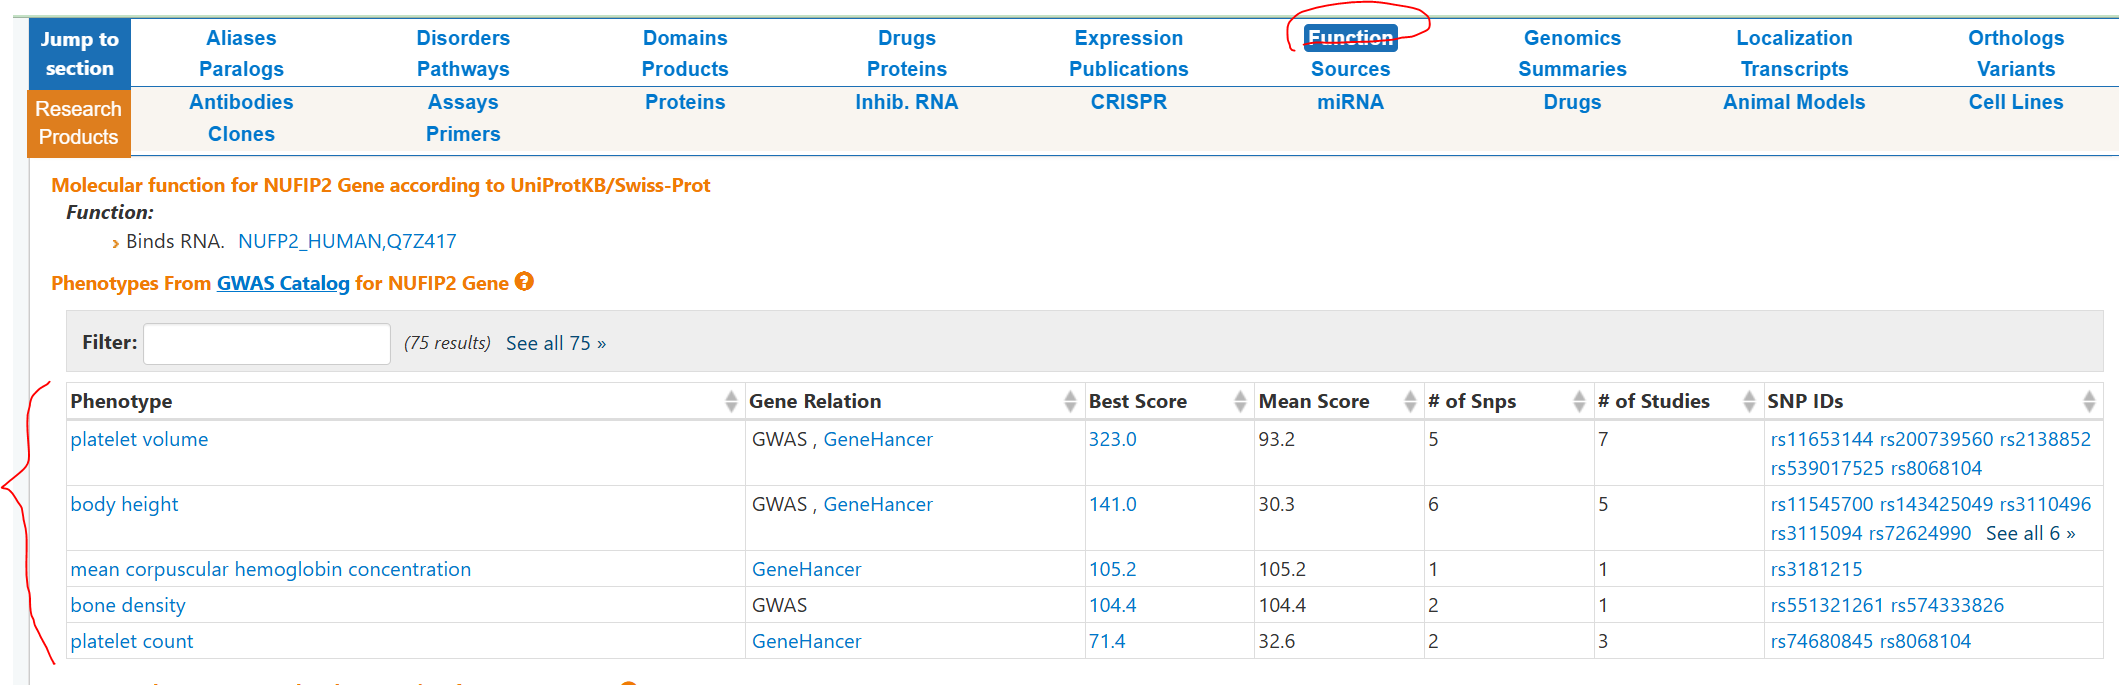

##### hub gene phenotype

In [ ]:
import re

os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data')
hub_gene_pheno=pd.read_csv('HubGenePhenotype.csv')

hub_gene_pheno['Phenotype'] = (
    hub_gene_pheno['Phenotype']
    .astype(str)  # Force conversion to string
    .str.lower()  # Lowercase
    .str.strip()  # Remove whitespace
)

# 1. Clean the Phenotype column (make consistent capitalization and fix spelling)
def clean_phenotype_name(name):
    # Convert to lowercase
    name = name.lower()
    # Remove extra whitespace
    name = ' '.join(name.split())
    # Common spelling corrections (add more as needed)
    corrections = {
        'diabete': 'diabetes',
        'obes': 'obesity',
        'hypertens': 'hypertension'
    }
    for wrong, right in corrections.items():
        if wrong in name:
            name = name.replace(wrong, right)
    # Capitalize first letter
    name = name.capitalize()
    return name
# Apply cleaning function
hub_gene_pheno['Phenotype'] = hub_gene_pheno['Phenotype'].apply(clean_phenotype_name)

In [ ]:
# 2. Prepare data
pheno_stats = (hub_gene_pheno.groupby(['Phenotype', 'ClassifType'])
               ['GeneID'].nunique()
               .unstack()
               .fillna(0))
pheno_stats['Total'] = pheno_stats.sum(axis=1)
pheno_stats = pheno_stats.sort_values('Total', ascending=False)

# 3. Create optimized horizontal plot
plt.figure(figsize=(7, 10))  # Taller figure since we're flipping axes

# Plot stacked horizontal bars
ax = pheno_stats.drop('Total', axis=1).plot(
    kind='barh',
    stacked=True,
    width=0.3,
    colormap='viridis',
    edgecolor='white',
    linewidth=0.1,
    ax=plt.gca()
)

# Truncate phenotype labels
n_letter = 80
trunc_labels = [x[:n_letter] + ('...' if len(x) > n_letter else '') for x in pheno_stats.index]
ax.set_yticklabels(trunc_labels, fontsize=8)


plt.xlabel('Number of Unique Genes', fontsize=6)

# Adjust legend
plt.legend(
    title='Network Membership',
    loc='upper right',
    prop={'size': 6},
    title_fontsize=8
)

plt.tight_layout()
#os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/outputs' )
#plt.savefig('pheno_classification_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Pathways

In [ ]:
def add_fold_enrichment(bl_kegg):
    df = bl_kegg.copy()
    df['FoldEnrichment'] = df['Hits'] / df['Expected']    
    return df

def compare_pathways(resp_kegg, persist_kegg, fdr_threshold=0.05):
    """
    Compare KEGG pathways between two DataFrames after FDR filtering.
    
    Parameters:
    - resp_kegg (pd.DataFrame): DataFrame containing responsive pathways (must have 'FDR' and 'Pathway' columns).
    - persist_kegg (pd.DataFrame): DataFrame containing persistent pathways (must have 'FDR' and 'Pathway' columns).
    - fdr_threshold (float): FDR cutoff (default: 0.05).
    
    Returns:
    - dict: A dictionary containing:
        - 'resp_filtered': Filtered resp_kegg (FDR < threshold).
        - 'persist_filtered': Filtered persist_kegg (FDR < threshold).
        - 'overlap_pathways': Pathways present in both filtered DataFrames.
        - 'unique_to_resp': Pathways only in resp_kegg (FDR < threshold).
        - 'unique_to_persist': Pathways only in persist_kegg (FDR < threshold).
    """
    # Step 1: Filter DataFrames by FDR
    resp_filtered = resp_kegg[resp_kegg['FDR'] < fdr_threshold].copy()
    persist_filtered = persist_kegg[persist_kegg['FDR'] < fdr_threshold].copy()
    print('resp_filtered', resp_filtered.shape, 'persist_filtered', persist_filtered.shape)
    
    # Step 2: Identify overlapping and unique pathways
    resp_pathways = set(resp_filtered['Pathway'])
    persist_pathways = set(persist_filtered['Pathway'])
    print( 'resp_pathways',len(list(resp_pathways)) , 'persist_pathways',len(list(persist_pathways)) ) 
    
    overlap_pathways = resp_pathways.intersection(persist_pathways)
    print( 'overlap_pathways', len(list(overlap_pathways)))
    
    unique_to_resp = resp_pathways - persist_pathways
    
    unique_to_persist = persist_pathways - resp_pathways
    print ( 'unique_to_resp', len(list(unique_to_resp)), 'unique_to_persist ', len(list(unique_to_persist )) )
    
    # Step 3: Return results as a structured dictionary
    results = {
        'resp_filtered': resp_filtered,
        'persist_filtered': persist_filtered,
        'overlap_pathways': overlap_pathways,
        'unique_to_resp': unique_to_resp,
        'unique_to_persist': unique_to_persist
    }
    
    return results

def create_fdr_fold_change_df(overlap_pathways, bl_kegg, pwl_kegg):
    """
    Create a DataFrame showing FDR and FoldEnrichment changes between bl_kegg and pwl_kegg for overlapping pathways.
    
    Parameters:
    - overlap_pathways (set): Set of pathway names that overlap between two conditions
    - bl_kegg (pd.DataFrame): Baseline KEGG results (must contain 'Pathway', 'FDR', and 'FoldEnrichment' columns)
    - pwl_kegg (pd.DataFrame): Post-treatment KEGG results (must contain 'Pathway', 'FDR', and 'FoldEnrichment' columns)
    
    Returns:
    - pd.DataFrame: Sorted DataFrame with pathways, FDR/FoldEnrichment values, changes, and direction of change
    """
    # Create DataFrame for overlapping pathways
    overlap_df = pd.DataFrame({
        'Pathway': list(overlap_pathways),
        'FDR_bl': [bl_kegg.loc[bl_kegg['Pathway'] == pathway, 'FDR'].values[0] for pathway in overlap_pathways],
        'FDR_pwl': [pwl_kegg.loc[pwl_kegg['Pathway'] == pathway, 'FDR'].values[0] for pathway in overlap_pathways],
        'FoldEnrichment_bl': [bl_kegg.loc[bl_kegg['Pathway'] == pathway, 'FoldEnrichment'].values[0] 
                              for pathway in overlap_pathways],
        'FoldEnrichment_pwl': [pwl_kegg.loc[pwl_kegg['Pathway'] == pathway, 'FoldEnrichment'].values[0] 
                                for pathway in overlap_pathways]
    })
    
    # Calculate FDR and FoldEnrichment changes
    overlap_df['FDR_change'] = overlap_df['FDR_pwl'] - overlap_df['FDR_bl']
    overlap_df['FoldEnrichment_change'] = overlap_df['FoldEnrichment_pwl'] - overlap_df['FoldEnrichment_bl']
    
    # Add change direction columns
    overlap_df['FDR_Change_Direction'] = overlap_df['FDR_change'].apply(
        lambda x: 'Less significant (FDR increased)' if x > 0 
                  else ('More significant (FDR decreased)' if x < 0 
                       else 'No change')
    )
    
    overlap_df['FoldEnrichment_Change_Direction'] = overlap_df['FoldEnrichment_change'].apply(
        lambda x: 'Increased' if x > 0 
                  else ('Decreased' if x < 0 
                       else 'No change')
    )
    
    # Sort by absolute FDR change (largest changes first)
    overlap_df_sorted = overlap_df.sort_values(by='FDR_change', ascending=False)
    
    return overlap_df_sorted

def plot_top_kegg_pathways(kegg_change_df, top_n=50, return_df=False):
    
    # Calculate average Fold Enrichment and FDR
    kegg_change_df['Avg_FoldEnrichment'] = (kegg_change_df['FoldEnrichment_bl'] + kegg_change_df['FoldEnrichment_pwl']) / 2
    kegg_change_df['FDR_avg'] = (kegg_change_df['FDR_bl'] + kegg_change_df['FDR_pwl']) / 2

    # Sort the dataframe by Avg_FoldEnrichment
    sorted_df = kegg_change_df.sort_values(by='Avg_FoldEnrichment', ascending=False).head(top_n)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the bar plot with color based on FDR_avg
    bars = ax.bar(
        sorted_df['Pathway'], 
        sorted_df['Avg_FoldEnrichment'], 
        color=plt.cm.viridis(sorted_df['FDR_avg'] / sorted_df['FDR_avg'].max())
    )

    # Add annotations for Avg_FoldEnrichment values
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=8
        )

    # Add colorbar to show FDR_avg values
    sm = plt.cm.ScalarMappable(
        cmap='viridis', 
        norm=plt.Normalize(vmin=sorted_df['FDR_avg'].min(), vmax=sorted_df['FDR_avg'].max())
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Average FDR')

    # Customize the plot
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylabel('Average Fold Enrichment')
    plt.title('Pathway Enrichment Analysis')
    plt.tight_layout()
    
    if return_df:
        return fig, sorted_df
    else:
        return fig

In [ ]:
from textwrap import wrap
from math import ceil
def plot_double_enrichment(df1, df2, 
                         fold_col='FoldEnrichment', 
                         fdr_col='FDR', 
                         pathway_col='Pathway',
                         title1='Dataset 1', 
                         title2='Dataset 2',
                         top_n=None, 
                         fig_width=12,  # Single width control
                         cmap='viridis_r',
                         max_label_length=30,
                         row_height=0.5,  # Height per row in inches
                         min_fig_height=6,  # Minimum figure height
                         max_fig_height=30): # Maximum figure height

    # Process both dataframes
    def prepare_df(df):
        sorted_df = df.sort_values(by=fold_col, ascending=True)
        if top_n is not None:
            sorted_df = sorted_df.head(top_n)
        return sorted_df
    
    sorted_df1 = prepare_df(df1)
    sorted_df2 = prepare_df(df2)
    
    # Calculate dynamic figure height
    n_items = max(len(sorted_df1), len(sorted_df2))
    fig_height = min(max(n_items * row_height, min_fig_height), max_fig_height)
    
    # Create figure with dynamic height
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height), 
                                  sharex=True, 
                                  constrained_layout=True)
    
    # Find global FDR range
    global_fdr_min = min(sorted_df1[fdr_col].min(), sorted_df2[fdr_col].min())
    global_fdr_max = max(sorted_df1[fdr_col].max(), sorted_df2[fdr_col].max())
    norm = plt.Normalize(vmin=global_fdr_min, vmax=global_fdr_max)
    
    # Dynamic font sizing
    def calculate_fontsize(n):
        return max(6, 10 - n//15)  # Decreases with more items but has minimum
    
    label_fontsize = calculate_fontsize(n_items)
    value_fontsize = max(label_fontsize - 1, 5)  # Slightly smaller than labels
    
    # Label wrapping function
    def wrap_labels(labels, max_length=max_label_length):
        return ["\n".join(wrap(str(label), max_length)) for label in labels]
    
    # Plotting function
    def plot_data(ax, df, title):
        y_pos = np.arange(len(df))
        bars = ax.barh(y_pos, df[fold_col],
                      color=plt.get_cmap(cmap)(norm(df[fdr_col])))
        
        # Add values
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.05*max(df[fold_col]),  # Slightly offset from bar
                   bar.get_y() + bar.get_height()/2,
                   f'{width:.2f}',
                   ha='left', va='center', 
                   fontsize=value_fontsize)
        
        # Y-axis setup
        ax.set_yticks(y_pos)
        ax.set_yticklabels(wrap_labels(df[pathway_col]), 
                          fontsize=label_fontsize)
        ax.set_xlabel(fold_col, fontsize=label_fontsize+1)
        ax.set_title(title, fontsize=label_fontsize+2, pad=10)
        ax.grid(axis='x', linestyle='--', alpha=0.4)
        ax.set_xlim(left=0)  # Start at zero
    
    # Plot both datasets
    plot_data(ax1, sorted_df1, title1)
    plot_data(ax2, sorted_df2, title2)
    print('##########', sorted_df1.columns)
    
    # Colorbar
    sm = plt.cm.ScalarMappable(
        cmap='viridis', 
        norm=plt.Normalize(vmin=sorted_df1['FDR'].min(), vmax=sorted_df1['FDR'].max())
    )
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=[ax1, ax2], location='right', pad=0.02)
    cbar.ax.tick_params(labelsize=label_fontsize)
    cbar.set_label(fdr_col, fontsize=label_fontsize+1)
    
    # Adjust spacing
    plt.subplots_adjust(hspace=0.3)  # Space between subplots
    
    return fig

In [ ]:
def pathway_pipeline(BLpathdata_dir, PWLpathdata_dir, top_n_intersec_pathways, pathtype):
    bl_pathdata= add_fold_enrichment (pd.read_csv(BLpathdata_dir))
    pwl_pathdata= add_fold_enrichment (pd.read_csv(PWLpathdata_dir))
    
    pathway_results=compare_pathways(bl_pathdata, pwl_pathdata, fdr_threshold=0.05)
    print('# BL paths',len(pathway_results['resp_filtered']))
    print('# PWL paths',len(pathway_results['persist_filtered']))
    print("Overlapping pathways:", pathway_results['overlap_pathways'])
    print("# :", len(pathway_results['overlap_pathways']))
    print('-------------------------------------------------------------')
    pathway_change_df=create_fdr_fold_change_df(pathway_results['overlap_pathways'], bl_pathdata, pwl_pathdata)
    fig, sorted_df = plot_top_kegg_pathways(pathway_change_df, top_n=top_n_intersec_pathways, return_df=True)
    #fig.savefig("kegg_bl&pwl_top30.pdf")
    print(" BL pathways only:", pathway_results['unique_to_resp'], '# of pathways: ', len(list(pathway_results['unique_to_resp']) ))
    print(' ')
    #bl_kegg[bl_kegg['Pathway'].isin(kegg_results['unique_to_resp'])].sort_values(by='FoldEnrichment', ascending=False)
    print("PWL pathways only:", pathway_results['unique_to_persist'], '# of pathways: ', len(list(pathway_results['unique_to_persist']) ))
    #pwl_kegg[pwl_kegg['Pathway'].isin(kegg_results['unique_to_persist'])].sort_values(by='FoldEnrichment', ascending=False)

    # Plot the two datasets
    fig = plot_double_enrichment(
        df1=bl_pathdata[bl_pathdata['Pathway'].isin(pathway_results['unique_to_resp'])].sort_values(by='FoldEnrichment', ascending=False),
        df2= pwl_pathdata[ pwl_pathdata['Pathway'].isin(pathway_results['unique_to_persist'])].sort_values(by='FoldEnrichment', ascending=False),
        title1= f'BL Exclusive {pathtype}',
        title2= f'PWL Exclusive {pathtype}')
    #fig.savefig('kegg_conditionExclusive.pdf', bbox_inches='tight', dpi=300)

#### KEGG

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/data_hubgene_ppi')
BLpathdata_dir='BL_network_KEGG_v3.csv'
PWLpathdata_dir='PWL_network_KEGG_v3.csv'
top_n_intersec_pathways=30
pathtype='KEGG'

pathway_pipeline(BLpathdata_dir, PWLpathdata_dir, top_n_intersec_pathways, pathtype)

'Hypothesis of Overlap pathways: 

they are pathwyas that obeisty-specific, can be improved by weight loss (that's why they appear in resp-network), but cannot be fully normalized (that's why they appear in persisent-network)

Hypothesis of BL only pathways:

which pathways are typically dysregulated in obesity before intervention;
<br>Tend to be normlaised by WL

Hypothesis of PWL only pathways:

which may change or emerge after weight loss (e.g., due to metabolic adaptation, inflammation resolution, or hormonal changes).

#### ------------------------------- BP

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/data_hubgene_ppi')
BLpathdata_dir='BL_network_BP_v3.csv'
PWLpathdata_dir='PWL_network_BP_v3.csv'
top_n_intersec_pathways=30
pathtype='BP'

pathway_pipeline(BLpathdata_dir, PWLpathdata_dir, top_n_intersec_pathways, pathtype)

### Disease

In [ ]:
os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/data_hubgene_ppi')
BLpathdata_dir='BL_network_Disease_v3.csv'
PWLpathdata_dir='PWL_network_Disease_v3.csv'
top_n_intersec_pathways=30
pathtype='Disease'

pathway_pipeline(BLpathdata_dir, PWLpathdata_dir, top_n_intersec_pathways, pathtype)

In [ ]:
def compare_pathways_test_bug(resp_kegg, persist_kegg, fdr_threshold=0.05):
    """
    Compare KEGG pathways between two DataFrames after FDR filtering.
    
    Parameters:
    - resp_kegg (pd.DataFrame): DataFrame containing responsive pathways (must have 'FDR' and 'Pathway' columns).
    - persist_kegg (pd.DataFrame): DataFrame containing persistent pathways (must have 'FDR' and 'Pathway' columns).
    - fdr_threshold (float): FDR cutoff (default: 0.05).
    
    Returns:
    - dict: A dictionary containing:
        - 'resp_filtered': Filtered resp_kegg (FDR < threshold).
        - 'persist_filtered': Filtered persist_kegg (FDR < threshold).
        - 'overlap_pathways': Pathways present in both filtered DataFrames.
        - 'unique_to_resp': Pathways only in resp_kegg (FDR < threshold).
        - 'unique_to_persist': Pathways only in persist_kegg (FDR < threshold).
    """
    # Step 1: Filter DataFrames by FDR
    resp_filtered = resp_kegg[resp_kegg['FDR'] < fdr_threshold].copy()
    persist_filtered = persist_kegg[persist_kegg['FDR'] < fdr_threshold].copy()
    
    # Step 2: Identify overlapping and unique pathways
    resp_pathways = set(resp_filtered['Pathway'])
    persist_pathways = set(persist_filtered['Pathway'])
    
    overlap_pathways = resp_pathways.intersection(persist_pathways)
    unique_to_resp = resp_pathways - persist_pathways
    unique_to_persist = persist_pathways - resp_pathways
    
    # Step 3: Return results as a structured dictionary
    results = {
        'resp_filtered': resp_filtered,
        'persist_filtered': persist_filtered,
        'overlap_pathways': overlap_pathways,
        'unique_to_resp': unique_to_resp,
        'unique_to_persist': unique_to_persist
    }
    
    return resp_filtered,persist_filtered,resp_pathways,persist_pathways

os.chdir('/home/jupy/miRNA/Acute_WL/miRNA_database_data/data_hubgene_ppi')
BLpathdata_dir='BL_network_BP_v3.csv'
PWLpathdata_dir='PWL_network_BP_v3.csv'
top_n_intersec_pathways=10
pathtype='BP'

bl_pathdata= add_fold_enrichment (pd.read_csv(BLpathdata_dir))
print('bl_pathdata.shape',bl_pathdata.shape)
pwl_pathdata= add_fold_enrichment (pd.read_csv(PWLpathdata_dir))
print('pwl_pathdata.shape',pwl_pathdata.shape)
    
    
resp_filtered,persist_filtered,resp_pathways,persist_pathways=compare_pathways_test_bug(bl_pathdata, pwl_pathdata, fdr_threshold=0.05)

#resp_filtered['Pathway'][resp_filtered['Pathway'].duplicated()].unique()
persist_filtered['Pathway'][persist_filtered['Pathway'].duplicated()].unique()